##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

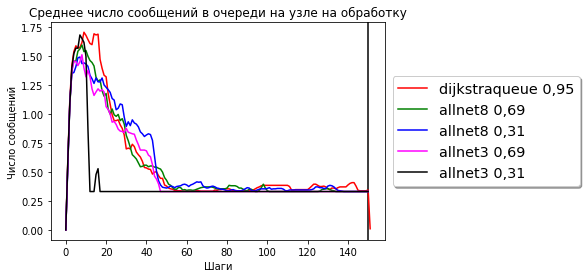

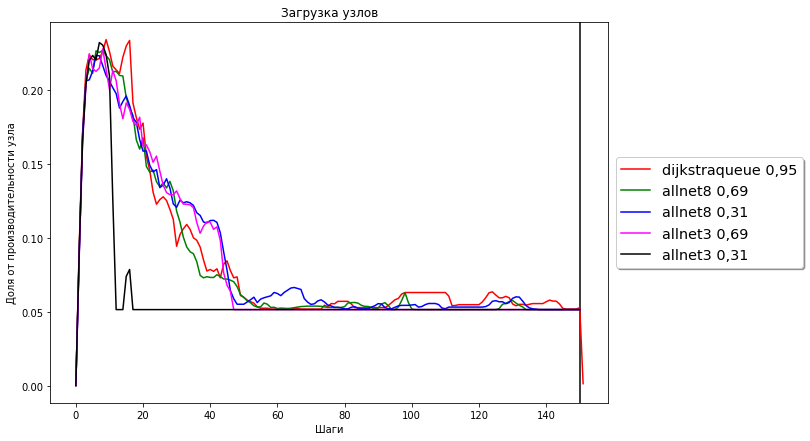

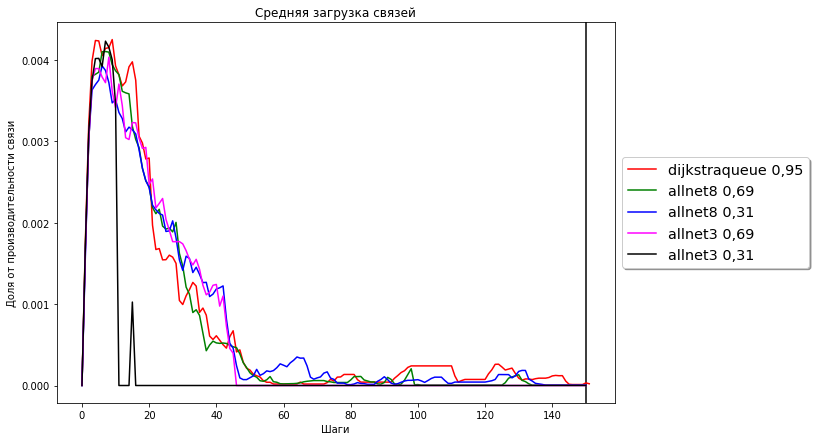

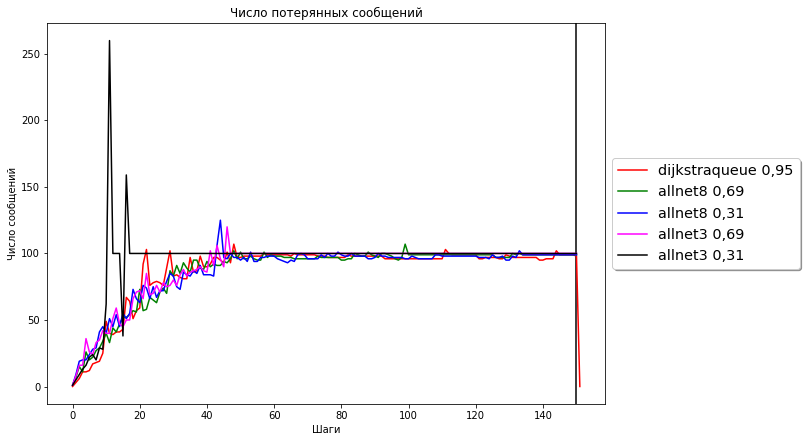

Доставлено 1858 Потеряно 87.6142% -dijkstraqueue 0,95
Доставлено 1899 Потеряно 87.3408% -allnet8 0,69
Доставлено 1848 Потеряно 87.6808% -allnet8 0,31
Доставлено 1567 Потеряно 89.5540% -allnet3 0,69
Доставлено 615 Потеряно 95.9003% -allnet3 0,31


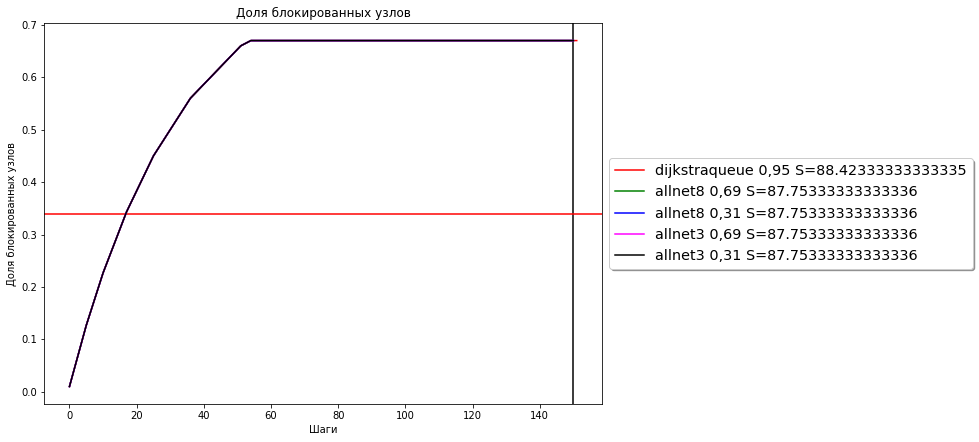

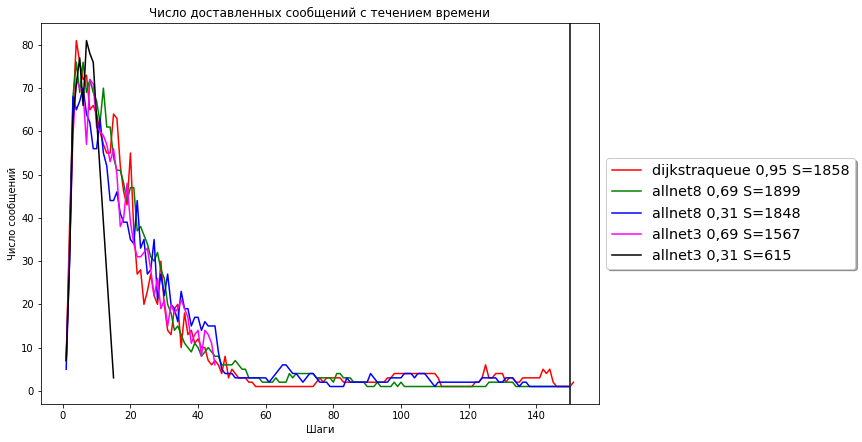

In [2]:
quantity = 100;
log_tags = [
{"tag":  "e8f7b484-2c02-4cd4-8ad2-2ca730e014a7", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "b939ee25-292e-49f3-bded-9cbeed27bdf6", "label": "allnet8 0,69", "color": "green"},
{"tag":  "215df08a-37e2-42fa-85ce-938026aff87f", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "884c5949-6895-4e1e-811e-3cf447f73f64", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "eafa7e81-f130-46a0-91d9-796cc36421e6", "label": "allnet3 0,31", "color": "black"},

]                           
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

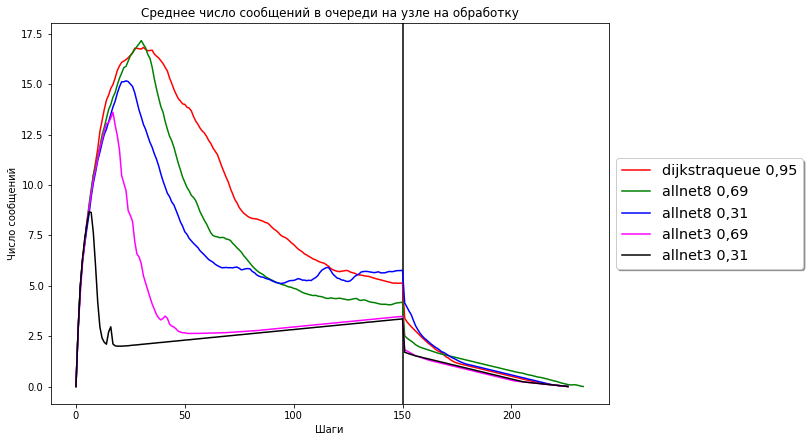

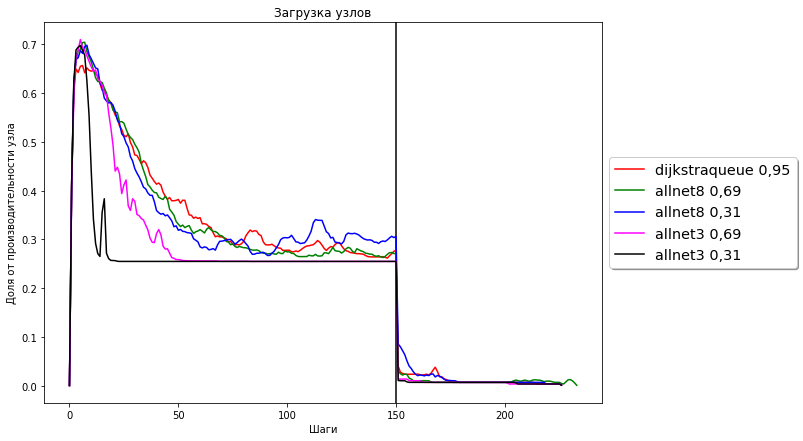

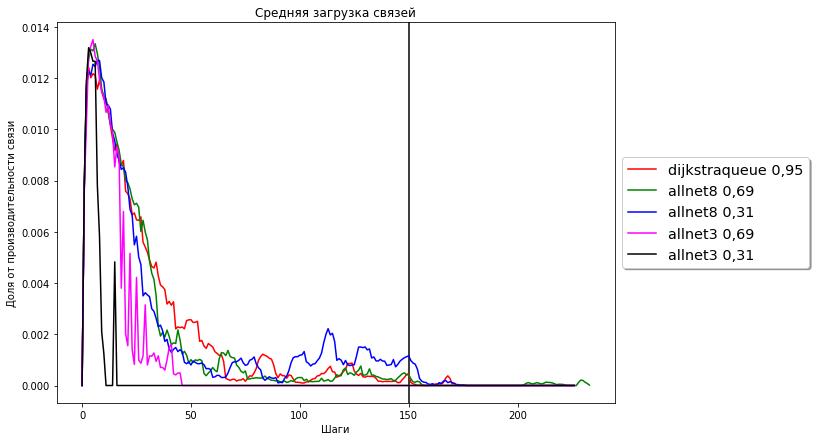

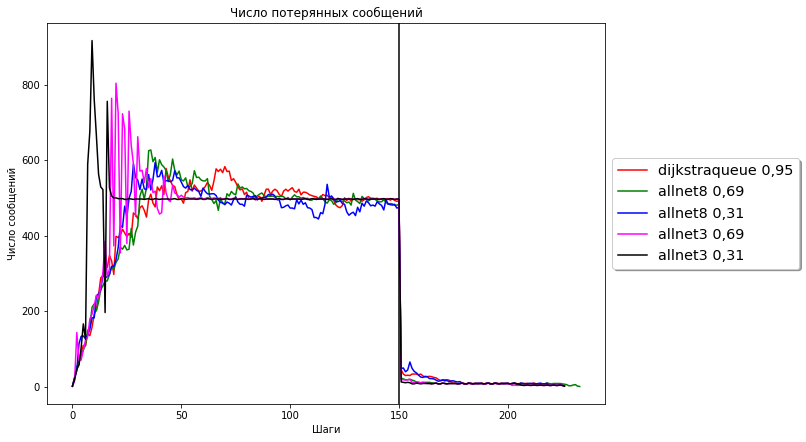

Доставлено 4259 Потеряно 94.3214% -dijkstraqueue 0,95
Доставлено 4733 Потеряно 93.6894% -allnet8 0,69
Доставлено 5004 Потеряно 93.3281% -allnet8 0,31
Доставлено 3177 Потеряно 95.7641% -allnet3 0,69
Доставлено 1176 Потеряно 98.4320% -allnet3 0,31


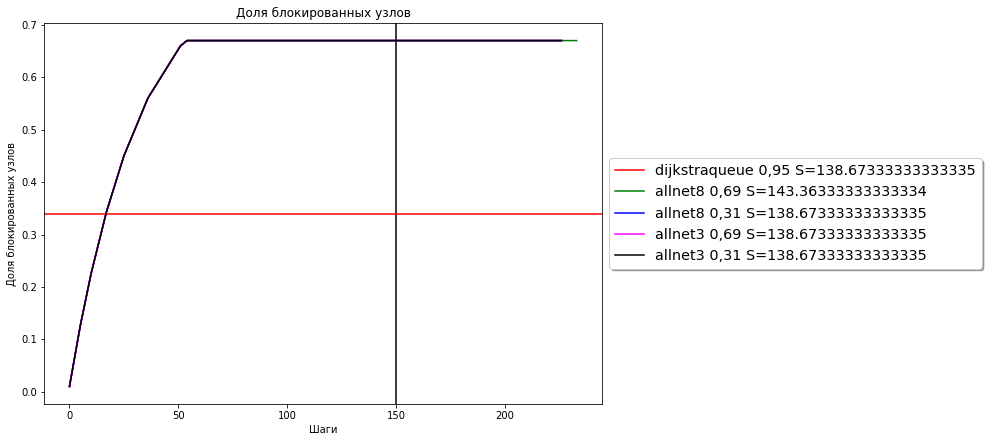

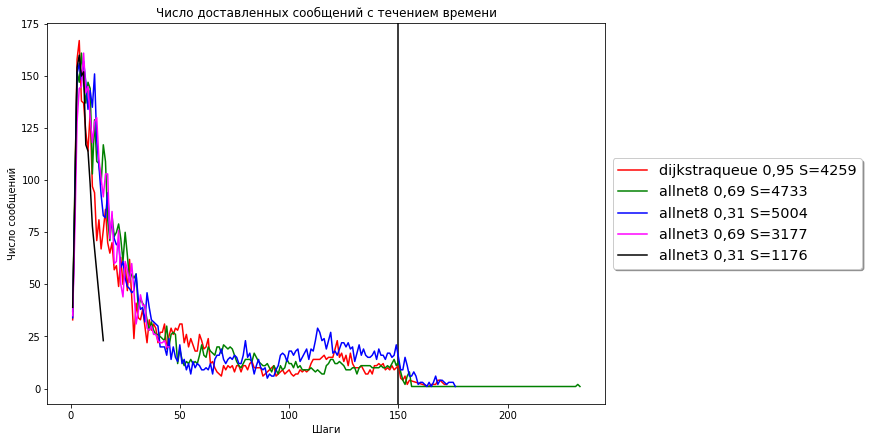

In [3]:
quantity = 500;
log_tags = [
{"tag":  "5c8b61c4-1144-4b82-9e9a-fd8ee148eaf9", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "da40439f-1ffc-47a0-a324-77a9fbe53817", "label": "allnet8 0,69", "color": "green"},
{"tag":  "34546ed4-831d-4b5b-9ff6-3fadbc753ada", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "3d31afb4-04f5-4b68-8b51-f30c2dce4278", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "f7db1e17-278a-4a5f-99d4-e8ad9e8e9b81", "label": "allnet3 0,31", "color": "black"},

] 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

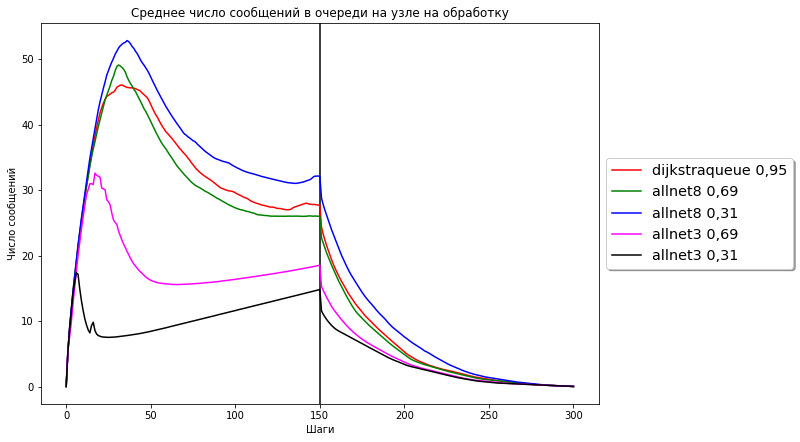

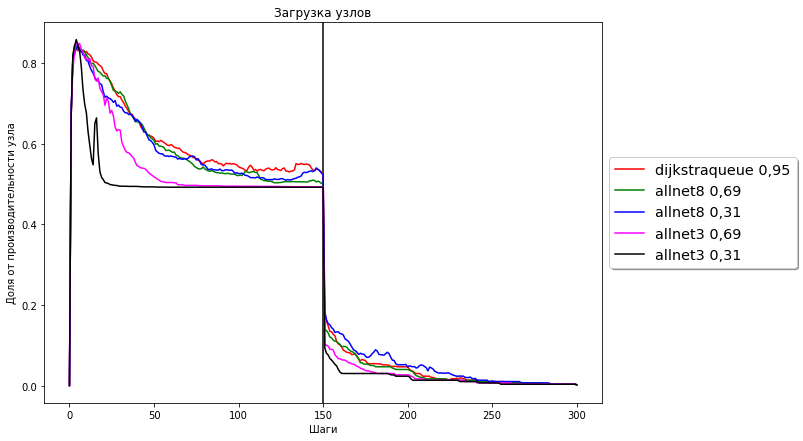

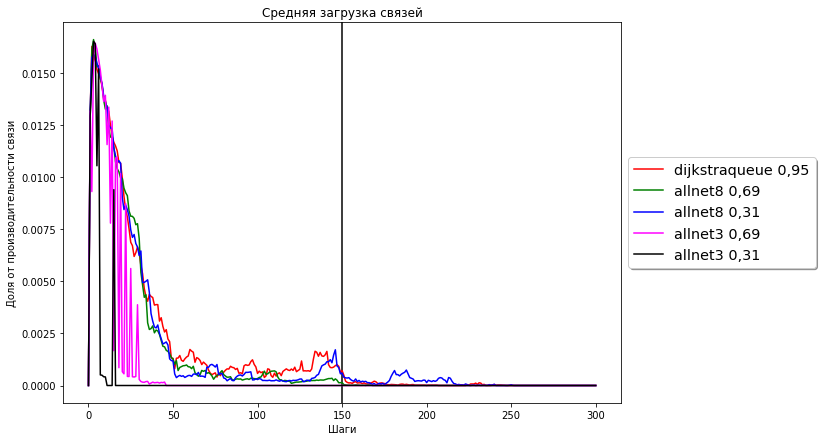

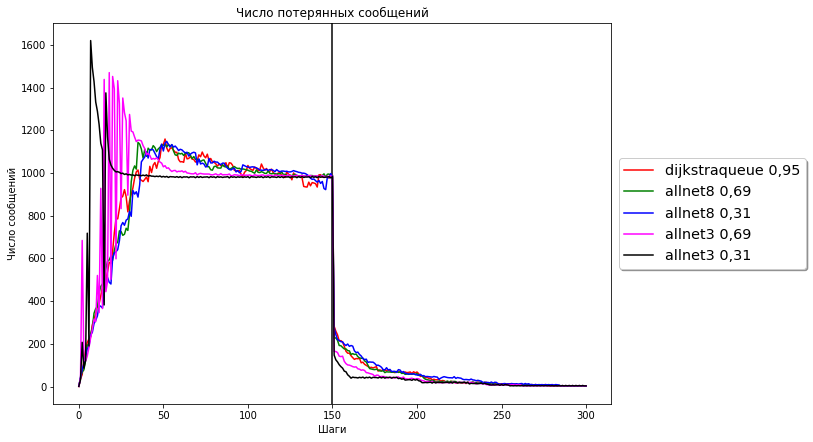

Доставлено 5098 Потеряно 96.6014% -dijkstraqueue 0,95
Доставлено 4652 Потеряно 96.8987% -allnet8 0,69
Доставлено 4578 Потеряно 96.9480% -allnet8 0,31
Доставлено 2044 Потеряно 98.6373% -allnet3 0,69
Доставлено 679 Потеряно 99.5473% -allnet3 0,31


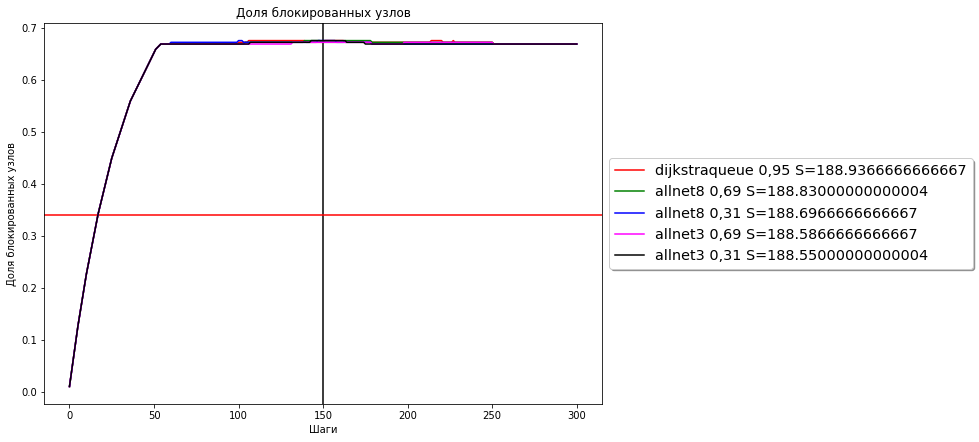

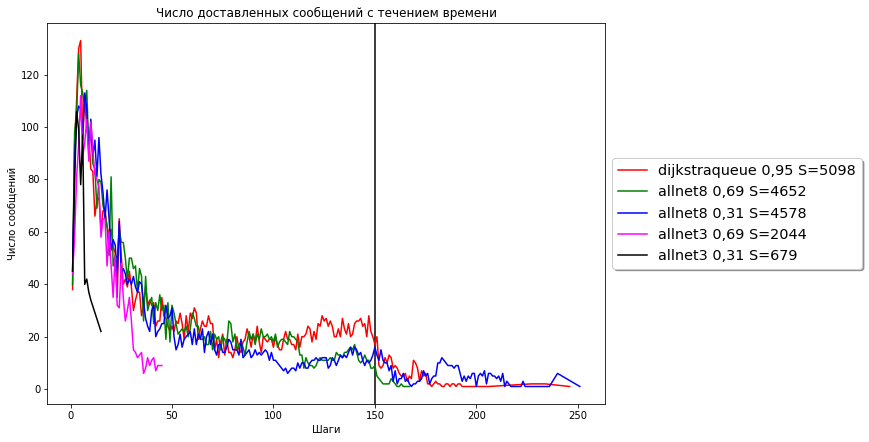

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "d51997b3-f228-4fa6-93a9-b8f7e6c72f41", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "a5dc009b-469d-4061-bb9d-db1ad789d454", "label": "allnet8 0,69", "color": "green"},
{"tag":  "9566a5bc-10ef-4d64-8c81-469992694483", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "e7980e22-1000-42f0-8dcb-ce8863f7e407", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "b5a42cfb-f51f-46e7-8223-1e71e44b1904", "label": "allnet3 0,31", "color": "black"},

]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

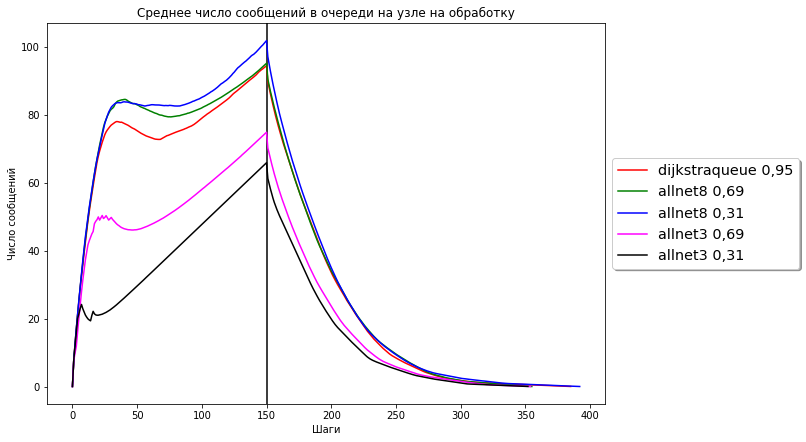

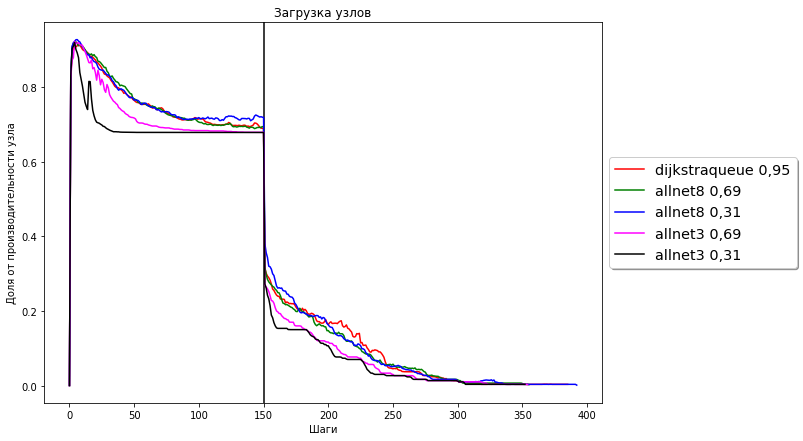

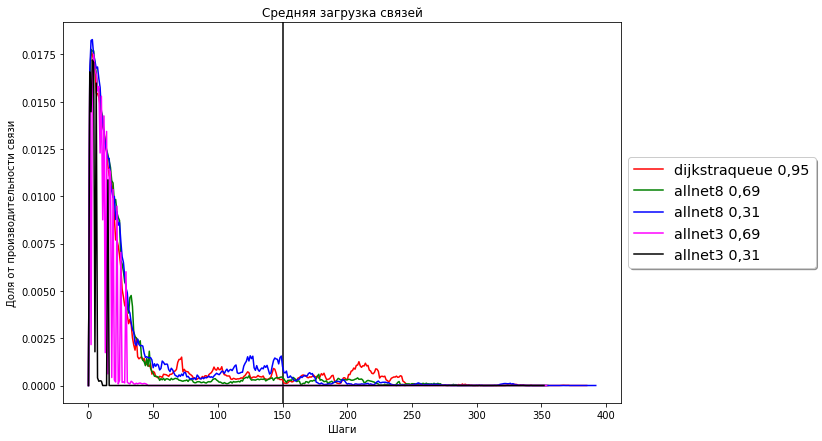

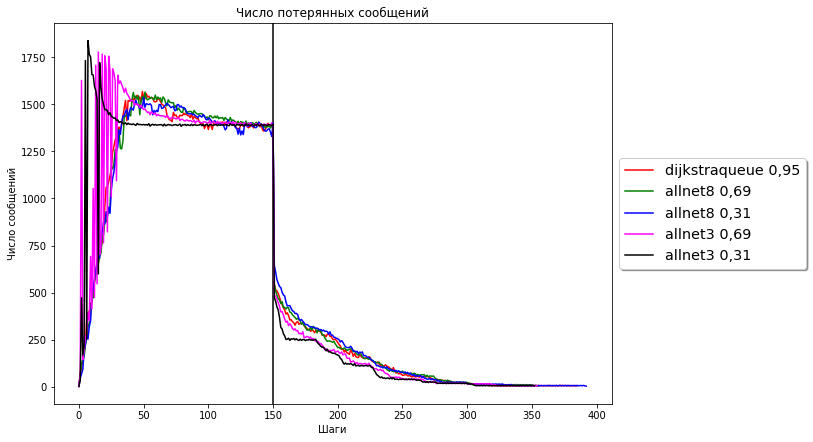

Доставлено 4874 Потеряно 97.8338% -dijkstraqueue 0,95
Доставлено 4086 Потеряно 98.1840% -allnet8 0,69
Доставлено 4408 Потеряно 98.0409% -allnet8 0,31
Доставлено 1465 Потеряно 99.3489% -allnet3 0,69
Доставлено 495 Потеряно 99.7800% -allnet3 0,31


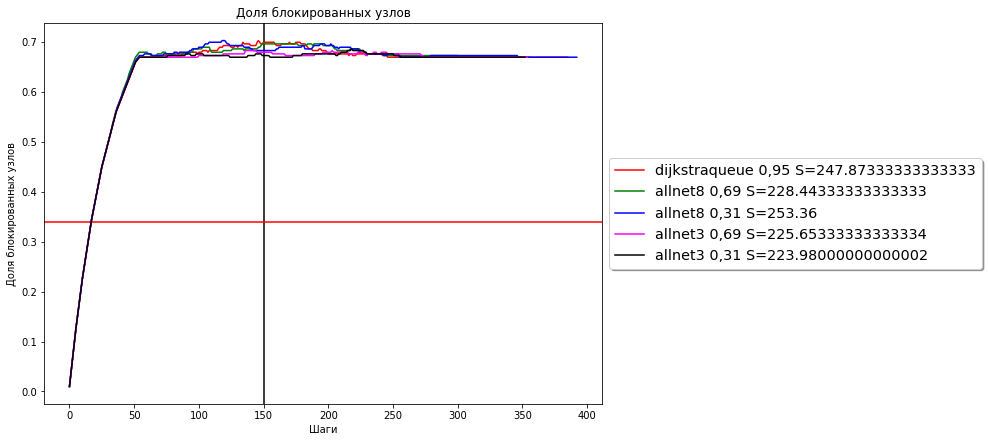

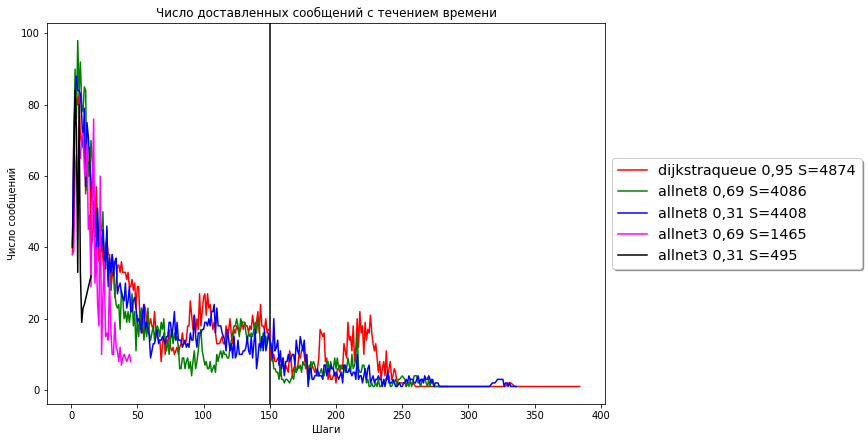

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "ebfae23a-5969-4183-8c80-e25d0dc849d4", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "460e4eef-8fb2-453c-be5c-b569f11d5623", "label": "allnet8 0,69", "color": "green"},
{"tag":  "5abe6418-6e05-43c3-82b4-257df9136880", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "53bddf1c-2d14-4840-bb3f-f7c86976e3ed", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "e8c8505e-d2e5-481e-a6f3-dd094451c702", "label": "allnet3 0,31", "color": "black"},

] 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 4163 Потеряно 90.7491% -dijkstraqueue 0,95
Доставлено 3896 Потеряно 91.3424% -allnet8 0,69
Доставлено 3837 Потеряно 91.4735% -allnet8 0,31
Доставлено 3401 Потеряно 92.4424% -allnet3 0,69
Доставлено 1217 Потеряно 97.2956% -allnet3 0,31


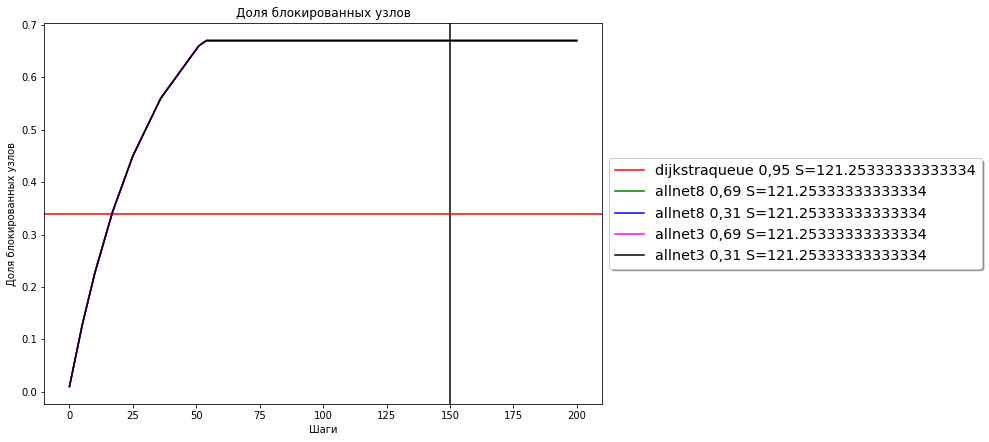

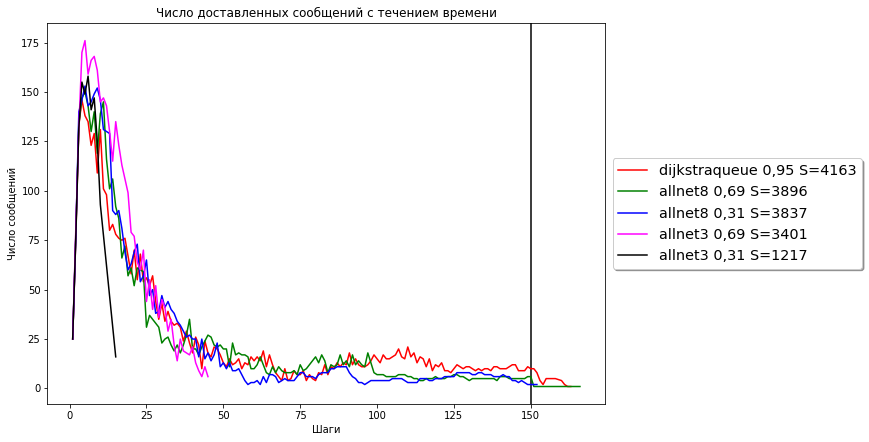

Доставлено 4441 Потеряно 95.7705% -dijkstraqueue 0,95
Доставлено 5216 Потеряно 95.0324% -allnet8 0,69
Доставлено 4795 Потеряно 95.4334% -allnet8 0,31
Доставлено 2548 Потеряно 97.5734% -allnet3 0,69
Доставлено 932 Потеряно 99.1124% -allnet3 0,31


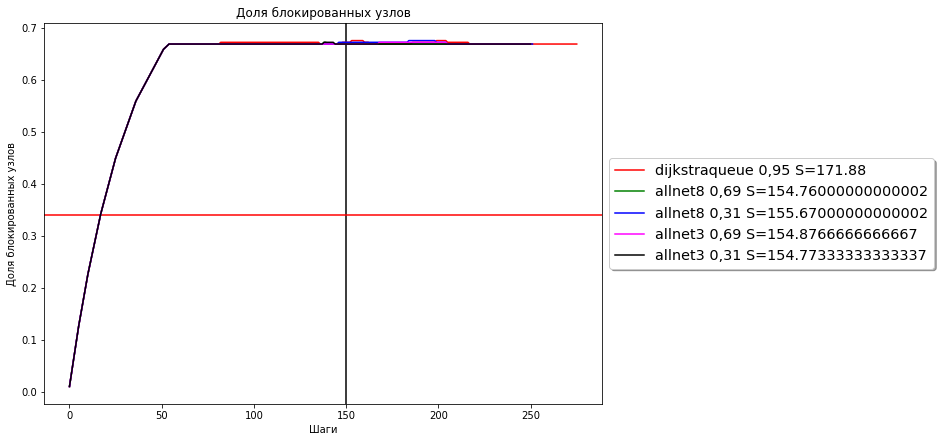

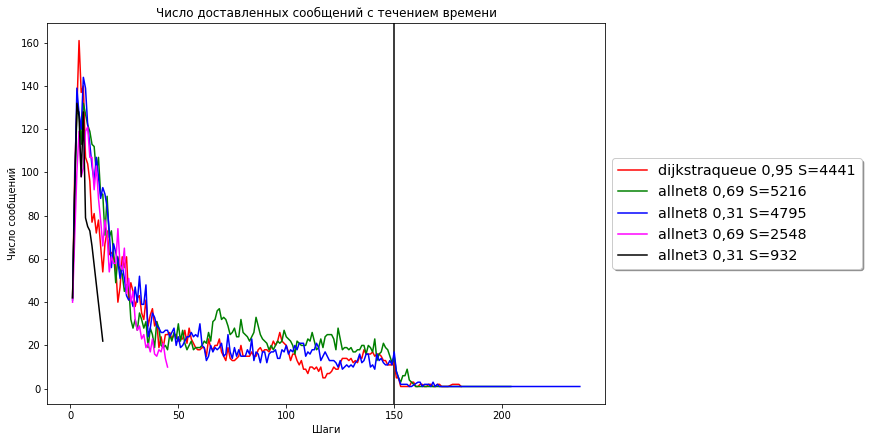

Доставлено 5402 Потеряно 95.9985% -dijkstraqueue 0,95
Доставлено 4931 Потеряно 96.3474% -allnet8 0,69
Доставлено 5001 Потеряно 96.2956% -allnet8 0,31
Доставлено 2195 Потеряно 98.3741% -allnet3 0,69
Доставлено 897 Потеряно 99.3356% -allnet3 0,31


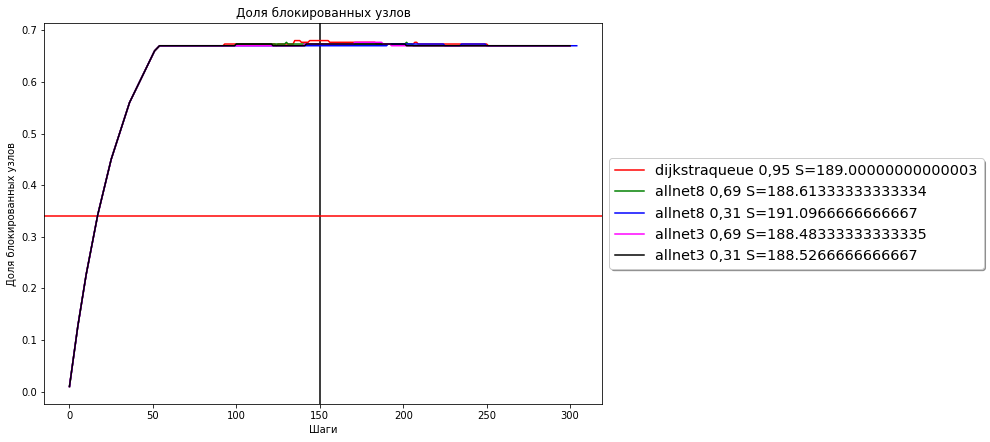

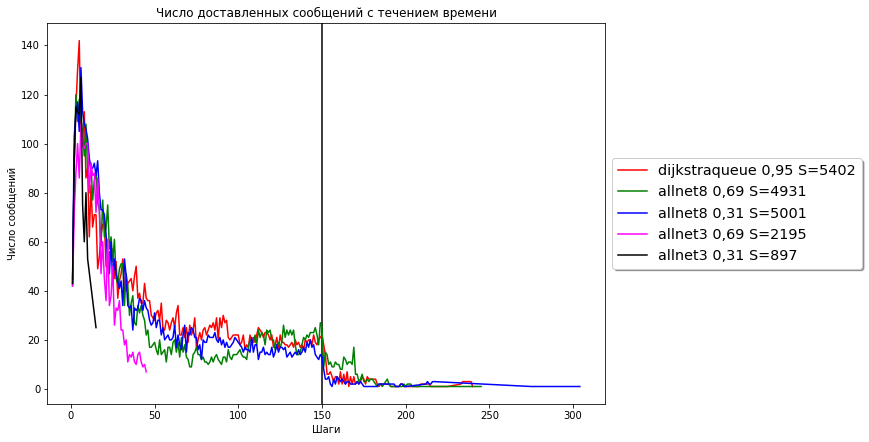

Доставлено 6153 Потеряно 96.8446% -dijkstraqueue 0,95
Доставлено 5029 Потеряно 97.4210% -allnet8 0,69
Доставлено 5275 Потеряно 97.2949% -allnet8 0,31
Доставлено 1633 Потеряно 99.1626% -allnet3 0,69
Доставлено 608 Потеряно 99.6882% -allnet3 0,31


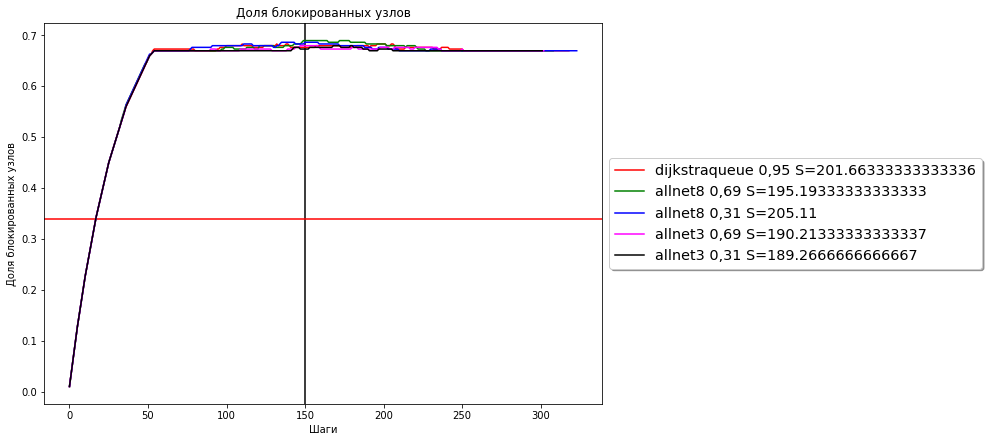

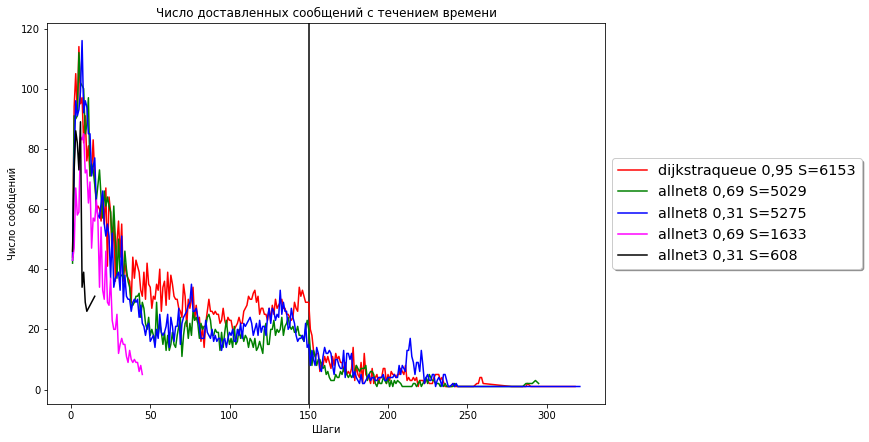

In [6]:
quantity = 300;
log_tags = [
{"tag":  "dfb40df7-fa68-419b-88d4-60b1bf0ba790", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "71c9ea9a-5efb-4f72-a379-6b55cb70d2c2", "label": "allnet8 0,69", "color": "green"},
{"tag":  "6f07cb1a-c2ce-4289-b6ef-c13173aab148", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "9cf58f4f-391d-4fe0-a62b-643adec1941f", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "e28ac59e-eb8f-41f4-9d15-83e1689d1883", "label": "allnet3 0,31", "color": "black"},

]
showStatBlocked();  
showStatMessage();
quantity = 700;
log_tags = [
{"tag":  "becf6456-633a-4f0b-a7eb-36223dcf2d64", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "aef4b5d5-fc35-4089-ae32-47e3aa9cd381", "label": "allnet8 0,69", "color": "green"},
{"tag":  "07339c49-3d60-4ad2-8f4c-78ba31c0f0ab", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "f99d39fb-697f-42ad-9fd0-f36b8c8f46a8", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "aa1af2e1-439c-4bd2-a936-3f8b29b82b9e", "label": "allnet3 0,31", "color": "black"},

]
showStatBlocked();  
showStatMessage();
quantity = 900;
log_tags = [
{"tag":  "d71c4fba-6377-43bb-8530-e1b80f2d943e", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "4942a703-cfe8-4f05-a09e-dfe817aff293", "label": "allnet8 0,69", "color": "green"},
{"tag":  "16694b29-cf08-45e4-b16b-d3febd3037a6", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "e10e4fdb-52c5-43d4-8090-5787e417747f", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "d29d0647-35ac-4e08-80f3-1daa523771f5", "label": "allnet3 0,31", "color": "black"},

]
showStatBlocked();  
showStatMessage();
quantity = 1300;
log_tags = [
{"tag":  "2784efc2-5e01-4ee3-bdae-db1be130452d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "3367894f-8013-4439-9394-d4bec56945b5", "label": "allnet8 0,69", "color": "green"},
{"tag":  "68195c07-2dca-40c3-b65d-7b21b0062190", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "9909af80-5ea7-4657-8d9f-c2298a216075", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "76245758-f8c2-45b2-9135-b505c86ec795", "label": "allnet3 0,31", "color": "black"},

]
showStatBlocked();  
showStatMessage();

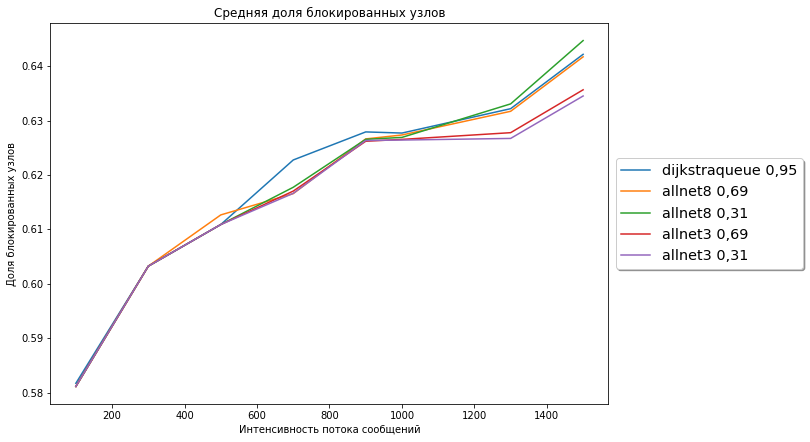

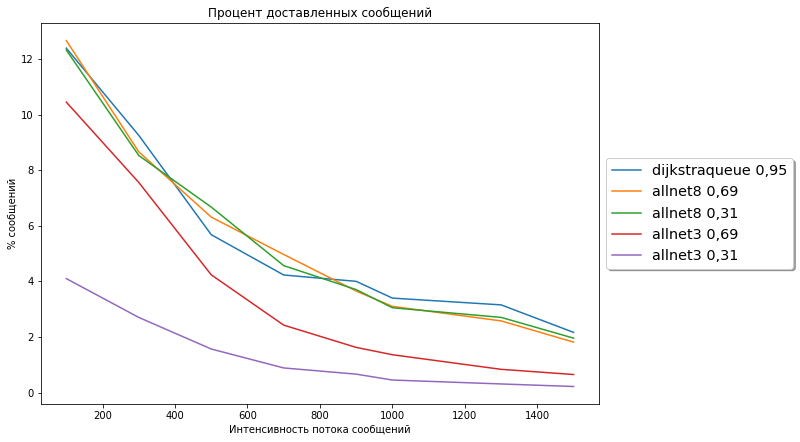

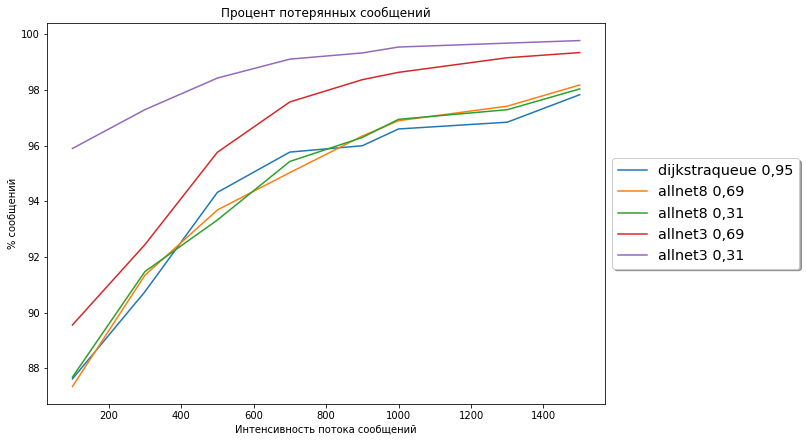

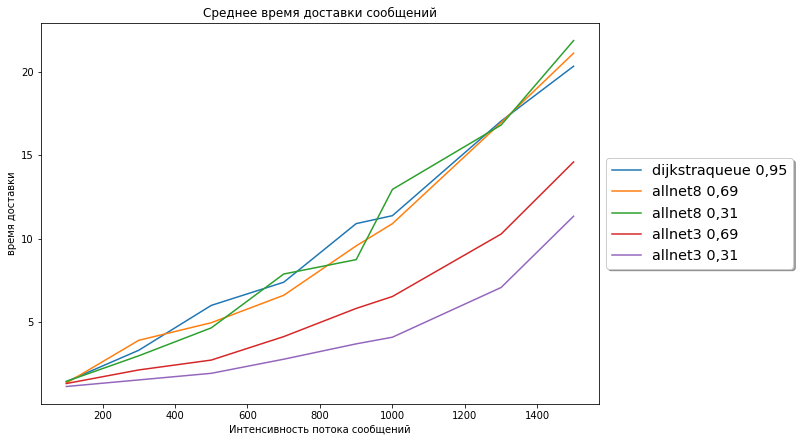

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

dijkstraqueue 0,95    0.618571
allnet8 0,69          0.617624
allnet8 0,31          0.618027
allnet3 0,69          0.616058
allnet3 0,31          0.615735

dijkstraqueue 0,95    94.466688
allnet8 0,69          94.532034
allnet8 0,31          94.561900
allnet3 0,69          96.357090
allnet3 0,31          98.636425

dijkstraqueue 0,95    9.722094
allnet8 0,69          9.416912
allnet8 0,31          9.665049
allnet3 0,69          5.930462
allnet3 0,31          4.183513
